In [9]:
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import healpy as hp
from scipy import interpolate
import os

from astropy.coordinates import SkyCoord, ICRS, Galactic

from combined_fit import spectrum as sp
from combined_fit import tensor as ts
from combined_fit import constant, map, draw, utilities

In [10]:
def contrast_hotspot(Flux_map, lHot, bHot, nside, galCoord, isAuger):
        npix = hp.nside2npix(nside)
        theta, phi = hp.pix2ang(nside, np.arange(npix))
        ra, dec = map.HealpyCoordToMap(galCoord, phi, theta)
        if galCoord: c = SkyCoord(l=ra, b=dec, frame='galactic', unit="rad")
        else: c = SkyCoord(ra=ra, dec=dec, frame='icrs', unit="rad")

        if isAuger: sel_dec = c.icrs.dec.degree <= 45
        else: sel_dec = c.icrs.dec.degree >= -15

        cHot = SkyCoord(l=lHot, b=bHot, frame='galactic', unit="deg")
        selHot = c.separation(cHot).deg < 40

        i_max = np.argmax(Flux_map[selHot])
        l_max, b_max = c.galactic.l.degree[selHot][i_max], c.galactic.b.degree[selHot][i_max]
        cmax = SkyCoord(l=l_max, b=b_max, frame='galactic', unit="deg")
        dist = cmax.separation(cHot).deg

        return np.max(Flux_map[selHot])/np.mean(Flux_map[sel_dec]), dist, l_max, b_max




In [11]:
# Physical parameters                                                                                                  
Dmin, Dcut = 0, 350#Mpc, minimum and maximum distance of the catalog                                                   
logEth_map = 19.6#Threshold energy in [eV] above which the map is computed                                             
includeMilkyWay = True#Add the Milky to the catalog or not                                                             
isSFR = True# True for SFRD, False for SMD                                                                             

#Plot parameters                                                                                                       
ShowMap, SavePlot = True, False#True to save the map                                                                   
galCoord = True # galactic coordinates if True, equatorial otherwise                                                   

# Best-fit parameters, inferred with Examples/Fit.py                                                                   
logRmin = 17.8 #Integrate the injected spectrum from logR_min to get total energy x k                                  
A       = [     1,       4,     14,     28,     56]
Z       = [     1,       2,  7, 14, 26]

In [12]:
hadr_model = "Sibyll" #for the record                                                                                  
if isSFR:
    key, trac = "sfrd", "logSFR"#solar mass / (yr.Mpc3), mass/yr                                                   
    k_transient =1E-4# best-case for B_LS = 10 nG                                                                  
    text_k = r"$k = "+ draw.latex_float(k_transient) + r"\, M_\odot^{-1}$"
    logRcut, gamma_nucl, gamma_p =  18.28, -0.36, 2.64
    E_times_k = [9.06E+45, 6.79E+45, 2.30E+46, 7.11E+45, 1.69E+45]
    unit_E_times_k = "erg per solar mass"
    sigma_shift_sys = 1.20
else:
    key, trac = "smd", "logM*"#solar mass / Mpc3, mass                                                             
    k_transient = 3E-15# best-case for B_LS = 10 nG                                                                
    text_k = r"$\dot{k} = "+ draw.latex_float(k_transient) + r"\, M_\odot^{-1}\, {yr}^{-1}$"
    logRcut, gamma_nucl, gamma_p =  18.41, 0.62, 3.02
    E_times_k = [2.27E+36, 2.13E+35, 1.33E+36, 1.78E+35, 1.77E+35]
    unit_E_times_k = "erg per solar mass per year"
    sigma_shift_sys = 1.54

In [13]:
Tensor = ts.upload_Tensor(logRmin = logRmin, logEmin = logEth_map)
tensor_parameters = [Tensor, E_times_k, A, Z, logRcut, gamma_nucl, gamma_p]

################# Compute the flux map ####################################                                            
###########################################################################                                            

####################### Background ########################################                                            
#Weights for total and background-only evolution                                                                       
S_z = ts.Load_evol(file = key+"_local.dat", key=key)
w_zR_nucl = sp.weight_tensor(S_z, gamma_nucl, logRcut)
w_zR_p = sp.weight_tensor(S_z, gamma_p, logRcut)

Dmin_CF, Dmax_CF = 1, 350
S_z_foreground = lambda z: S_z(z)*(constant._fz_DL(z)>=Dmin_CF)*(constant._fz_DL(z)<Dmax_CF)
w_zR_foreground_nucl = sp.weight_tensor(S_z_foreground, gamma_nucl, logRcut)
w_zR_foreground_p = sp.weight_tensor(S_z_foreground, gamma_p, logRcut)

# Background and foreground flux                                                                                       
logEth, J_total = sp.Compute_integral_spectrum(Tensor, E_times_k, A, Z, w_zR_nucl, w_zR_p)
logEth, J_foreground = sp.Compute_integral_spectrum(Tensor, E_times_k, A, Z, w_zR_foreground_nucl, w_zR_foreground_p)
print("Fraction of foreground flux (1-350 Mpc):",J_foreground/J_total)

# Get the isotropic background                                                                                         
nside = 64
J_background = J_total-J_foreground
iso_Map = np.ones(hp.nside2npix(nside))*J_background
####################### Foreground ########################################                                            

# Get the catalog                                                                                                      
galaxy_parameters_selected = map.load_Catalog(galCoord, Dmin, Dcut, tracer=trac, includeMilkyWay = includeMilkyWay)
galaxy_parameters_foreground = map.load_Catalog(galCoord, Dmin_CF, Dmax_CF, tracer=trac, includeMilkyWay = includeMilkyWay)

Rmean_foreground, map_arbitrary_units_foreground = map.map_arbitrary_units_with_all_cuts(galaxy_parameters_foreground,\
 tensor_parameters, k_transient, galCoord, nside)

Rmean, map_arbitrary_units = map.map_arbitrary_units_with_all_cuts(galaxy_parameters_selected, tensor_parameters, k_transient, galCoord, nside)

aniso_Map = map_arbitrary_units*J_foreground/np.mean(map_arbitrary_units_foreground)#mean could also be limited to dec\


Fraction of foreground flux (1-350 Mpc): 0.9736782532805226


In [14]:
####################### Sum ###############################################
# Smooth the flux map at physical angular scale
smooth = "fisher"
radius_Rmean = utilities.theta_mean_deg(Rmean) #deg
text_deflection = r"$\theta = "+str(np.around(radius_Rmean, decimals = 1))+r"$°"
Flux_map = aniso_Map + iso_Map
if radius_Rmean>3:#if smaller than 3deg the smoothing is equivalent to nothing
    Flux_map = map.LoadSmoothedMap(Flux_map, radius_Rmean, nside, smoothing=smooth)
print("Mean deflection", np.around(radius_Rmean, decimals = 1), "deg at R = ", np.around(Rmean, decimals = 1),"V")

# Smooth the flux map at display angular scale	
smooth = "top-hat"
radius = 25 #deg	
#Flux_map = map.LoadSmoothedMap(Flux_map, radius, nside, smoothing=smooth)
print("Contrast ", np.around(np.max(Flux_map)/np.min(Flux_map), decimals = 1))
################################## Plots ##################################
###########################################################################


Mean deflection 17.6 deg at R =  3.2795969923110845e+18 V
Contrast  4.4


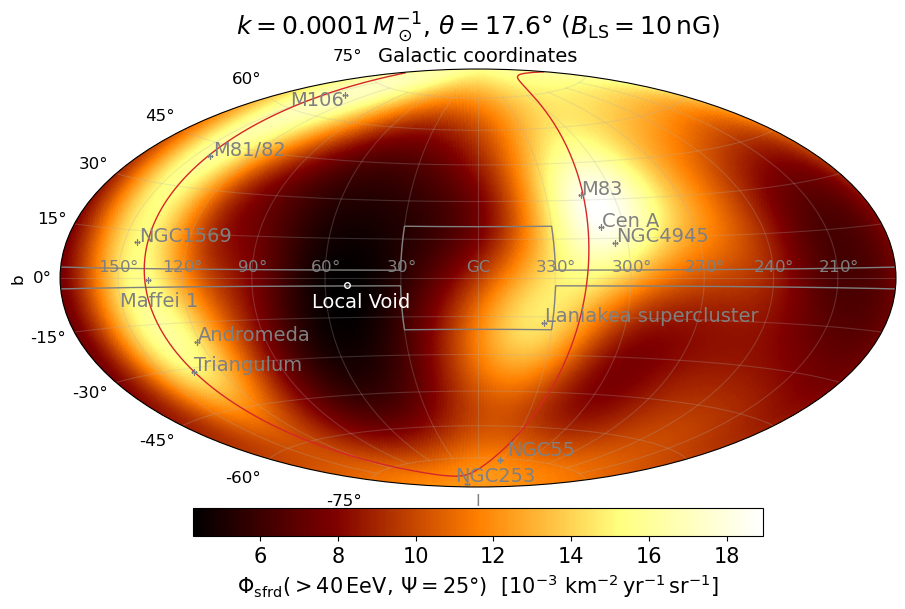

In [16]:
#Display parameters of the maps                                                                                        
if ShowMap:
    if galCoord: ax_title = "Galactic coordinates"
    else: ax_title = "Equatorial coordinates"
    fig_name = "uhecr_fluxmap_"+str(np.around(logEth, decimals=2))+"_"+key+"_"+str(np.around(constant.B_LGMF_nG, decimals=2))+"_"+str(k_transient)
    if smooth=="fisher": tex_ang = r"\theta"
    elif smooth=="top-hat": tex_ang = r"\Psi"
    Eth = np.around(np.power(10,logEth-18)).astype(int)
    norm_fact_title = 1E3
    color_bar_title = r"$\Phi_{\rm "+ key +r"}(>" + str(Eth) + r"\, {\rm EeV},\, "+tex_ang+" = "+ str(radius) +r"$°)"+ r"  $[10^{-3}\ \rm km^{-2}\, yr^{-1}\, sr^{-1}]$"
    title = text_k+", "+text_deflection+r" ($B_{\rm LS} ="+str(constant.B_LGMF_nG) +r"\,$nG)"

    #Plot                                                                                                          
    plt.rcParams.update({'font.size': 14,'legend.fontsize': 12})
    map.PlotHPmap(norm_fact_title*Flux_map, nside, galCoord, title, color_bar_title, ax_title, fig_name = fig_name, write= SavePlot)

